In [1]:
### 1. Importing Required Modules & Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import parallel_coordinates
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import sklearn.cluster as cluster
import scipy.optimize as opt
import matplotlib.gridspec as gridspec 

### 2. Defining Functions for fitting

In [4]:
#Functions used for this projects mentioned below


    #PART 2-FITTING Functions defined below

def exp_growth(time, scale_val, growth_val):
    """ Calculating exponential_function 'xf' with scale value and growth value as free_parameters"""
    
    xf = scale_val*np.exp(growth_val*(time-1960)) 
    
    return xf
        

def logistics(time, scale_val, growth_val, time0):
    """ Calculating logistics_function 'lm' with scale_value & growth_value
    and time'0' as the triggering point as free parameter_values"""
    
    lf = scale_val/(1.0+np.exp(-growth_val*(time-time0)))
    
    return lf


def err_ranges(data, modl, parameter, sigma_val):
    
    """Calculates the upper_limits and lower_limits for the corresponding function.
    The parameter and sigma for single value. Function values are calculated for 
    all combination of +&- sigmas and the minimum and maximum is identified."""

    import itertools as iter
    
    # initiate arrays for lower/upper_limits
    lower_lim = modl(data, *parameter)
    upper_lim = lower_lim
    
    # holding upper and lower limits for parameters into a list
    uplow_lim = []
    
    #iteration
    for q,t in zip(parameter, sigma_val):
        pmin_val = q-t
        pmax_val = q+t
        uplow_lim.append((pmin_val, pmax_val))
        
    pmix_val = list(iter.product(*uplow_lim))
    
    for q in pmix_val:
        y_modl = modl(data, *q)
        lower_lim = np.minimum(lower_lim, y_modl)
        upper_lim = np.maximum(upper_lim, y_modl)
        
    return lower_lim, upper_lim


def fit_plot(data, xaxis, yaxis, fit_param, xlbl, ylbl, title, cl1, cl2):
    
    """ Simple Fitting plot by taking data & axis values with lables and color parameters"""
    
    plt.figure()
    plt.plot(data[xaxis], data[yaxis], label="Data", color=cl1)
    plt.plot(data[xaxis], data[fit_param], label="Fit", color=cl2)

    plt.legend()
    plt.title(title)
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

def fit_err_plot(data, low, up, xaxis, yaxis, fit_param, xlbl, ylbl, title, cl1, cl2, cl3):
    
    """ Plotting the Fitting plot with Error / confidence values obtained w.r.t the fitting parameters.
        This function takes, data with lower and upper limits with x & y axis parameters"""
    
    plt.figure()
    plt.title(title)
    plt.plot(data[xaxis], data[yaxis], label="Data", color=cl1)
    plt.plot(data[xaxis], data[fit_param], label="Fit", color=cl2)

    plt.fill_between(data[xaxis], low, up, alpha=0.9, color=cl3)
    plt.legend()
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()
    
def best_fit_plot(data, env_data, forcast, low, up, xaxis, yaxis, xlbl, ylbl, title, col1, col2, col3):
    """ Plotting the Best Fitting plot with Error / confidence values obtained w.r.t the fitting parameters.
        This function takes, data with lower & upper limits with x & y axis parameters. Also passing confidence
        value as the envelop for the fitted data"""
    
    plt.figure()
    plt.title(title)
    plt.plot(data[xaxis], data[yaxis], label=ylbl, color=col1)
    plt.plot(env_data, forcast, label="Forecast", color=col2)

    plt.fill_between(env_data, low, up, alpha=0.9, color=col3)
    plt.legend()
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

### 3. Defining Global Variables and Parameters

In [8]:
#Defining Global Variables & List used for the use of data manipulation

Forest_Area = "AG.LND.FRST.K2"
CO2 = "EN.ATM.CO2E.PC"
Population = "SP.POP.TOTL"

Energy_use = "EG.USE.PCAP.KG.OE"
Arable_Land = "AG.LND.ARBL.ZS"
Renewable_Euse = "EG.FEC.RNEW.ZS"

#Indicator_replace list used to replace the Indicator code with an understandig words
Indicator_replace = {"EN.ATM.CO2E.PC":"CO2","AG.LND.FRST.K2":"Forest_Area","SP.POP.TOTL":"Population",
                  "EG.USE.PCAP.KG.OE":"Energy_use","AG.LND.ARBL.ZS":"Arable_Land","EG.FEC.RNEW.ZS":"Renewable_Euse"}

#Indicator_map used for maping the data-frame with corresponding indicators used by World bank data
Indicator_map = ["EN.ATM.CO2E.PC","AG.LND.FRST.K2","SP.POP.TOTL","EG.USE.PCAP.KG.OE","AG.LND.ARBL.ZS","EG.FEC.RNEW.ZS"]

### 4. Reading Data Frames using Funtion From the World Bank Data File

In [9]:
#Assigning World Bank Data file name to a variable
wb_file_name = 'World_Bank_Data_File.csv'

In [10]:
#Using World Bank Reader function defined in the function section to generate 2x data frame as per the assignment requirement
country_df, year_df = World_Bank_Reader(wb_file_name)

### 5. Re-arranging Data frame for the Analysis

#### 5.1 Arranging Data Frame

In [13]:
# Filtering out the required indicators for the anlysis from the previously defined Indicator Map list
year_df_new = year_df[year_df['Indicator Code'].isin(Indicator_map)]

In [14]:
# Replacing Not Identifiable Indicator code in to a known Identifiers
year_df_new["Indicator Code"].replace(Indicator_replace, inplace=True)

year_df_new = year_df_new.copy(deep=True) #To avoid warning related to the 'caveat'

In [15]:
# Droping Country Name  & Indicator Name as it is already defined
year_df_new = year_df_new.drop(['Country Code', 'Indicator Name'], axis=1, inplace=False)

In [16]:
country_data = year_df_new.reset_index()

In [17]:
#Normalizing the index for the easy analysis
country_data.drop(['index'], axis=1, inplace=True)

In [18]:
stat_data = country_data.groupby(['Country Name', 'Indicator Code']).aggregate('mean')

In [19]:
df_env_f = stat_data.stack().unstack(level=1)

stat_data2 = df_env_f.groupby(['Country Name']).aggregate('mean')

In [20]:
stat_data_orig = stat_data2.reset_index()

 ##Normalization

###### 6.1 Checking the Statistics Parmeters on the Original Data

Compare some results and showing our findings

### 10.1 Generating the Time series data of India and China

In [28]:
# Extracting population data of India & China from the world bank data frame using pandas data frame slicing

pop_stat = df_env_f.loc[['India'], ['Population']]

pop_stat_chn = df_env_f.loc[['China'], ['Population']]

# Removing the indexing for the time series analysis
pop_stat_orig = pop_stat.reset_index()

pop_stat_orig_chn = pop_stat_chn.reset_index()

# Renaming the default column name to 'Years'

pop_stat_orig.rename({'level_1':'Years'}, axis=1, inplace=True)

pop_stat_orig_chn.rename({'level_1':'Years'}, axis=1, inplace=True)

pop_stat_orig.head()

Indicator Code,Country Name,Years,Population
0,India,1960,450547675.0
1,India,1961,459642166.0
2,India,1962,469077191.0
3,India,1963,478825602.0
4,India,1964,488848139.0


### 10.2 Finding the Year when the Population Growth Start Increasing Exponentially to Define the model range

In [29]:
pop_stat_orig[['Population', 'Years']].values[25]  #Population in 1985

array([784360012.0, '1985'], dtype=object)

In [30]:
pop_stat_orig[['Population', 'Years']].values[40]   #Population in 2000

array([1056575548.0, '2000'], dtype=object)

### 10.3 Converting World Bank Data values from String to Numeric

In [31]:
#Converting String to Numeric (as the data that have extracted data from the CSV considered as the String)

pop_stat_orig['Population'] = pop_stat_orig['Population'].astype(int)

pop_stat_orig['Years'] = pop_stat_orig['Years'].astype(int)

pop_stat_orig_chn['Population'] = pop_stat_orig_chn['Population'].astype(int) 

pop_stat_orig_chn['Years'] = pop_stat_orig_chn['Years'].astype(int)

### 10.4 Fitting with  Exponential function Model & Forcasting with Uncertainity values

#### 10.4.1 Fitting using Exponential Function with Default Parameters & Values

In [32]:
# fit exponential growth with default parameters

popt, covar = opt.curve_fit(exp_growth, pop_stat_orig["Years"], pop_stat_orig["Population"])


In [33]:
# use *popt to pass on the fit parameters used for the modeling

pop_stat_orig["pop_exp"] = exp_growth(pop_stat_orig["Years"], *popt)


Exponential Fit parameter [5.72589619e-15 9.99999997e-01]


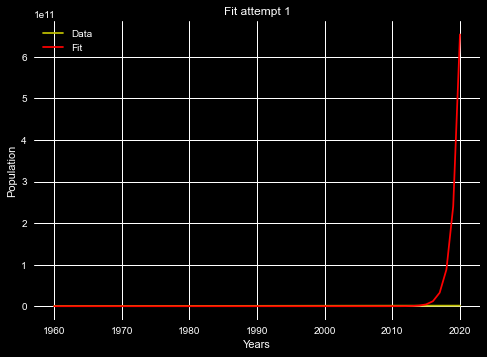

In [34]:
# Plotting the Fitting Attempt Using the values received from the Curve_Fit() and default data

print("Exponential Fit parameter", popt)

# Calling custom plot function defined before to plot the fit model Red & Yellow

fit_plot(pop_stat_orig, "Years", "Population", "pop_exp", "Years", "Population", "Fit attempt 1", 'y', 'r')


#### 10.4.2 Finding a start approximation & Fitting Attempt 2 (setting population parameter ( popt )values)

In [35]:
# Finding the required start value for the time series data
# After many trials The exponential factor  with 4e8 giving better result
# Growth factor of 0.02 is giving a comprimisable fit

popt = [4e8, 0.02]

pop_stat_orig["pop_exp"] = exp_growth(pop_stat_orig["Years"], *popt)


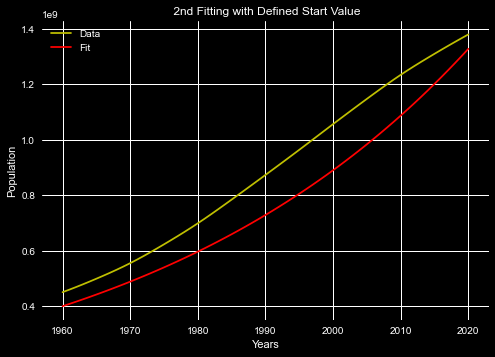

In [36]:
# Calling pre-defined Plotting function for the Fitted Model

fit_plot(pop_stat_orig, "Years", "Population", "pop_exp", "Years", "Population", 
          " 2nd Fitting with Defined Start Value", 'y', 'r')


#### 10.4.3 Final Fitting using Curve_Fit ( by applying the best Fit parameters obtained above)

In [37]:
# fit exponential growth by applying the best Fit parameters obtained above (we use curve_fit for the fitting of exponential model)
popt, covar = opt.curve_fit(exp_growth, pop_stat_orig["Years"], 
                            pop_stat_orig["Population"], p0=[4e8, 0.02])

pop_stat_orig["pop_exp"] = exp_growth(pop_stat_orig["Years"], *popt)

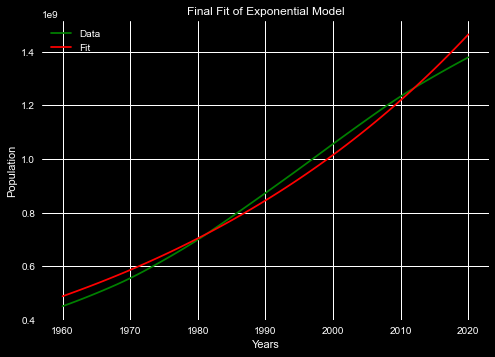

Fit parameter [4.87722568e+08 1.83358271e-02]


In [38]:
# Calling pre-defined Plotting function for the Fitted Model & Displaying Fit Parameters

fit_plot(pop_stat_orig, "Years", "Population", "pop_exp", "Years", "Population", 
         "Final Fit of Exponential Model", 'g', 'r')

print("Fit parameter", popt) 


#### 10.4.4 Finding Exponential Model Error Ranges

In [39]:
# Finding the upper and lower limits of the error ranges using Error Range Funtion
# extracting the sigma value from the Diagonal of the Covariance-Matrix
sigma = np.sqrt(np.diag(covar))

# Calling the Pre-defined Error Range Funtion to find the error ranges
low, up = err_ranges(pop_stat_orig["Years"], exp_growth, popt, sigma)

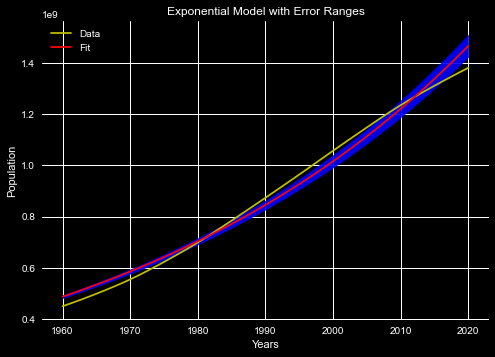

Sigma [6.15699323e+06 2.90579129e-04]


In [40]:
# Calling pre-defined Plotting funtion for the Fitted Model

fit_err_plot(pop_stat_orig, low, up, "Years", "Population", "pop_exp", "Years", "Population", 
             "Exponential Model with Error Ranges", 'y', 'r', 'b')

print("Sigma", sigma)

#### 10.4.5 Forcasting the Data till the year 2050 using Exponential Model

In [41]:
# Forcasting the data using on upcoming years with upper & lower limits. ie every next 10 year till the year 2050
print("Forcasted population")

low, up = err_ranges(2030, exp_growth, popt, sigma)
print("2030 between ", low, "and", up)

low, up = err_ranges(2040, exp_growth, popt, sigma)
print("2040 between ", low, "and", up)

low, up = err_ranges(2050, exp_growth, popt, sigma)
print("2050 between ", low, "and", up)


Forcasted population
2030 between  1703107441.0877156 and 1819178163.8685684
2040 between  2039912609.6471274 and 2191637328.119036
2050 between  2443324099.588051 and 2640353910.0262485


#### 10.4.6 Forcasting the Data till the year 2050 using Exponential Model with Mean & Uncertainity Values

In [42]:
# Printing the Exponenital Model Prediction Uncertainity

print("Forcasted population")
low, up = err_ranges(2030, exp_growth, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2030:", mean, "+/-", pm)

low, up = err_ranges(2040, exp_growth, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2040:", mean, "+/-", pm)

low, up = err_ranges(2050, exp_growth, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2050:", mean, "+/-", pm)

Forcasted population
2030: 1761142802.478142 +/- 58035361.3904264
2040: 2115774968.883082 +/- 75862359.2359544
2050: 2541839004.80715 +/- 98514905.2190988


### 10.5 Fitting with Logistics function Model & Forcasting with Uncertainity values

#### 10.5.1 Finding a start approximation & Improved Fitting

In [43]:
# estimated turning year: 1985 to 2000 , The growth what we have seen in 270 Million that is in 2000, 
# population reaches to 1.05Billion
# population in 1985: about 780 million
# best fitting functions happening with growth factor of 0.05 & exponential value of 8e8 with start value 1985

popt = [2e9, 0.05, 1985]

# Calling the pre defined logistics model function with indicators

pop_stat_orig["pop_log"] = logistics(pop_stat_orig["Years"], *popt)


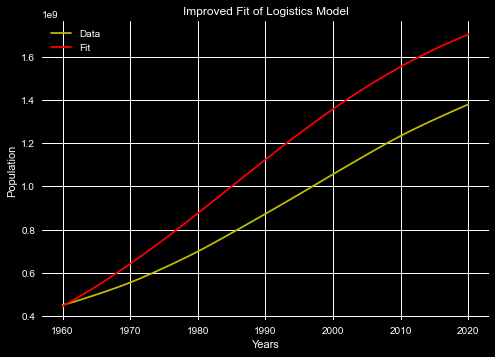

In [44]:
# Calling pre-defined fiting plot
fit_plot (pop_stat_orig, "Years", "Population", "pop_log", "Years", 
          "Population", "Improved Fit of Logistics Model", 'y', 'r')


In [45]:
#For the china population model 3e9 value works better than 2e9 with growth factor of 0.05
popt_chn = [3e9, 0.05, 1985]

# Callign the pre defined logistics model function with indicators
pop_stat_orig_chn["pop_log_chn"] = logistics(pop_stat_orig_chn["Years"], *popt_chn)


#### 10.5.2 Final Fitting using Curve_Fit (  Logistics Model )

In [46]:
# fit logistics model growth by applying the best Fit parameters obtained from above step to teh curve_fit funtion

popt, covar = opt.curve_fit(logistics, pop_stat_orig["Years"], pop_stat_orig["Population"], 
                            p0=(2e9, 0.05, 1985))

# Calling Logistics Model Function with popt obtained from the curve fit
pop_stat_orig["pop_log"] = logistics(pop_stat_orig["Years"], *popt)

In [47]:
# fitting of data using China
popt_chn, covar_chn = opt.curve_fit(logistics, pop_stat_orig_chn["Years"], pop_stat_orig_chn["Population"], 
                            p0=(2e9, 0.05, 1985))

# Calling Logistics Model Function with popt obtained from the curve fit
pop_stat_orig_chn["pop_log_chn"] = logistics(pop_stat_orig_chn["Years"], *popt_chn)

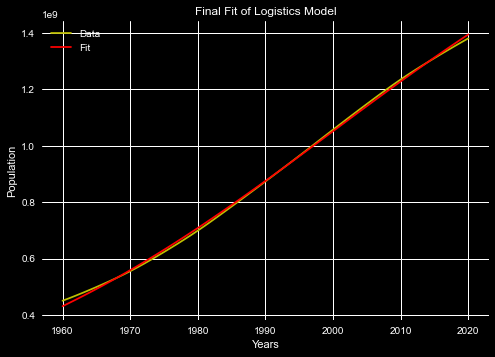

Fit parameter [2.09990515e+09 3.38906823e-02 1.99993111e+03]


In [48]:
fit_plot (pop_stat_orig,"Years", "Population", "pop_log", "Years", "Population",
          "Final Fit of Logistics Model", 'y', 'r')

print("Fit parameter", popt)


#### 10.5.3 Finding Error Ranges ( Logistics Model )

In [49]:
# Finding the upper and lower limits of the error ranges using Error Range Function for India
# extract the sigmas from the diagonal of the covariance matrix

sigma = np.sqrt(np.diag(covar))
print(sigma)

# Calling the Pre-defined Error Range Function to find the error ranges in the Logistics Model
low, up = err_ranges(pop_stat_orig["Years"], logistics, popt, sigma)


[3.55092043e+07 4.88492570e-04 1.05305467e+00]


In [50]:
# Finding the upper and lower limits of the error ranges using Error Range Function for China
# extract the sigmas from the diagonal of the covariance matrix

sigma_chn = np.sqrt(np.diag(covar_chn))
print(sigma_chn)

# Calling the Pre-defined Error Range Function to find the error ranges into the Logistics Model
low_chn, up_chn = err_ranges(pop_stat_orig_chn["Years"], logistics, popt_chn, sigma_chn)

[7.96541096e+06 6.90120901e-04 2.20568725e-01]


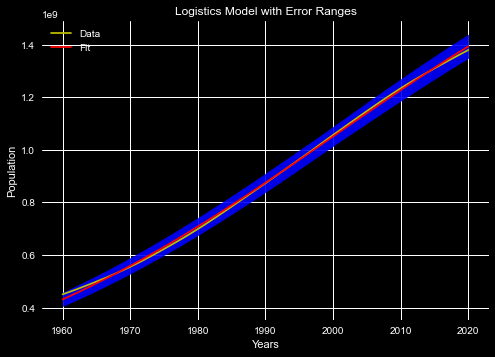

Sigma [3.55092043e+07 4.88492570e-04 1.05305467e+00]


In [51]:
# Calling pre-defined Plotting funtion for the Fitted Model
fit_err_plot(pop_stat_orig, low, up, "Years", "Population", "pop_log", "Years",
             "Population", "Logistics Model with Error Ranges", 'y', 'r', 'b')

print("Sigma", sigma)

#### 10.5.4 Forcasting the Data till the year 2050 ( Logistics Model )

In [52]:
# Forcasting the data using on upcoming years with upper & lower limits. ie every next 10 year using Logistics Model

print("Forcasted population of India")

low, up = err_ranges(2030, logistics, popt, sigma)
print("2030 between ", low, "and", up)

low, up = err_ranges(2040, logistics, popt, sigma)
print("2040 between ", low, "and", up)

low, up = err_ranges(2050, logistics, popt, sigma)
print("2050 between ", low, "and", up)

Forcasted population of India
2030 between  1496601464.7162757 and 1590001397.698015
2040 between  1623390354.680622 and 1717631137.3391705
2050 between  1728226701.2280939 and 1821295107.8463514


In [53]:
# Forcasting the data using on upcoming years with upper & lower limits. ie every next 10 year using Logistics Model
print("Forcasted population of China
      
low_chn, up_chn = err_ranges(2030, logistics, popt_chn, sigma_chn)
print("2030 between ", low_chn, "and", up_chn)
      
low_chn, up_chn = err_ranges(2040, logistics, popt_chn, sigma_chn)
print("2040 between ", low_chn, "and", up_chn)
      
low_chn, up_chn = err_ranges(2050, logistics, popt_chn, sigma_chn)
print("2050 between ", low_chn, "and", up_chn)

SyntaxError: EOL while scanning string literal (Temp/ipykernel_19916/769171549.py, line 2)

#### 10.5.5 Forcasting the Data till the year 2050 using Logistics Model with Mean & Uncertainity Values

In [54]:
print("Forcasted population of India")
low, up = err_ranges(2030, logistics, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2030:", mean, "+/-", pm)

low, up = err_ranges(2040, logistics, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2040:", mean, "+/-", pm)

low, up = err_ranges(2050, logistics, popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2050:", mean, "+/-", pm)

Forcasted population of India
2030: 1543301431.2071452 +/- 46699966.49086964
2040: 1670510746.0098963 +/- 47120391.32927418
2050: 1774760904.5372226 +/- 46534203.30912876


In [55]:
print("Forcasted population of China")
low_chn, up_chn = err_ranges(2030, logistics, popt_chn, sigma_chn)
mean = (up_chn+low_chn)/2.0
pm = (up_chn-low_chn)/2.0
print("2030:", mean, "+/-", pm)

low_chn, up_chn = err_ranges(2040, logistics, popt_chn, sigma_chn)
mean = (up_chn+low_chn)/2.0
pm = (up_chn-low_chn)/2.0
print("2040:", mean, "+/-", pm)

low_chn, up_chn = err_ranges(2050, logistics, popt_chn, sigma_chn)
mean = (up_chn+low_chn)/2.0
pm = (up_chn-low_chn)/2.0
print("2050:", mean, "+/-", pm)

Forcasted population of China
2030: 1452518112.029258 +/- 11639228.47832489
2040: 1481316506.3379145 +/- 10729460.590591788
2050: 1500093284.8315427 +/- 9981376.40419054


### 10.6 Comparing the Exponential & Logistics Model Result

#### Population Forcast of INDIA

#### Population Forcast of CHINA

### 10.7 Plotting the best fitting function and the confidence range

In [56]:
# Defining the envelop for the predicted year including the available year ranges
year_ind = np.arange(1960, 2050)

# Assigning the above created year value with population parameter obtained above to get the forecast shape
forecast_ind = logistics(year_ind, *popt)

In [57]:
# Findign the lower & upper ranges of the envelop using the error range funtion defined before
low_ind, up_ind = err_ranges(year_ind, logistics, popt, sigma)

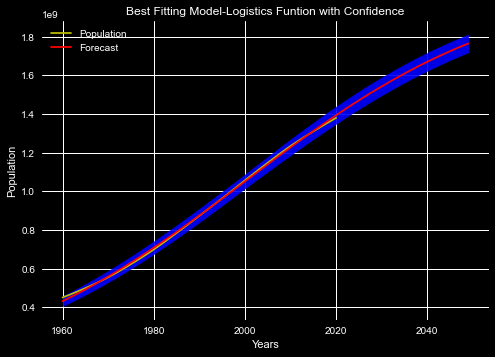

In [58]:
# Calling pre-defined Plotting function for the Fitted Model

best_fit_plot(pop_stat_orig, year_ind, forecast_ind, low_ind, up_ind, "Years",
              "Population", "Years", "Population", "Best Fitting Model-Logistics Funtion with Confidence",
              'y', 'r','b')

In [59]:
# Defining the envelop for the predicted year including the available year ranges
year_chn = np.arange(1960, 2050)

# Assigning the above created year value with population parameter obtained above to get the forecast shape
forecast_chn = logistics(year_chn, *popt_chn)

In [60]:
# Findign the lower & upper ranges of the envelop using the error range funtion defined before
low_chn, up_chn = err_ranges(year_chn, logistics, popt_chn, sigma_chn)

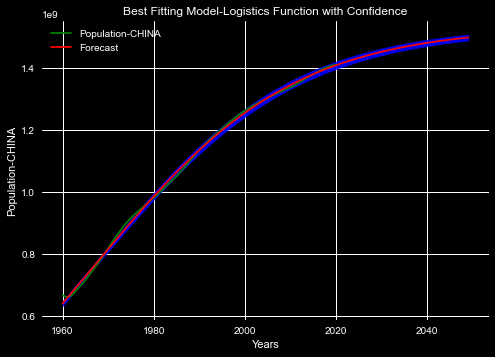

In [61]:
# Calling pre-defined Plotting function for the Fitted Model
best_fit_plot(pop_stat_orig_chn, year_chn, forecast_chn, low_chn, up_chn,
              "Years", "Population", "Years", "Population-CHINA", "Best Fitting Model-Logistics Function with Confidence",
              'g', 'r', 'b')

# 11. Conclusion